# Домашнее задание 2

In [1]:
import pymorphy3
import re
import nltk
from nltk.corpus import stopwords

import csv
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import torch

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from wordcloud import WordCloud

from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback



times = {}
methods = ['CountVectorizer', 'TF-IDF', 'Word2Vec']

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leranikitina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Часть 1:

- Рассчитайте метрику TF-IDF для любых трех песен на одном языке по вашему выбору.
- Сравните TF-IDF с другими методами векторизации текста, такими как Count Vectorizer, Word2Vec или Doc2Vec.
- Проведите исследование, используя полученные преобразованные данные. Какие слова/фразы встречаются чаще всего, а какие реже.

Для анализа возьмем следующие 3 песни на русском языке:
 - Zoloto "Стихнет мотор"
 - Диктофон "Космонавт"
 - Земфира "Чайка"


In [2]:
zoloto_text = '''
Уже под окнами дрожит такси
Не умоляй меня и не проси
Подъезды помнят мой уставший стиль
И кнопки в лифте кем-то сожжены
Слышу крики мужа и жены
Семейной жизни все подробности
Стихнет мотор
Улетучится запах выхлопных газов
Ты уткнёшься в монитор
Не заметив, как капнуло с левого глаза
Выпадет снег и закроет всю ржавчину старых карнизов
И целый век ты будешь ждать моего появления снизу
Снизу
Сырые трещины двухцветных стен
Потоком бешеным стекают в Рим
И засыхают насовсем
Пожарный выход из мудрёных схем
Мне говорит, что мы сейчас сгорим
И отдаёт меня Москве
Стихнет мотор
Улетучится запах выхлопных газов
Ты уткнешься в монитор
Не заметив, как капнуло с левого глаза
Выпадет снег и закроет всю ржавчину старых карнизов
И целый век ты будешь ждать моего появления снизу
Снизу
Выпадет снег и закроет всю ржавчину старых карнизов
И целый век ты будешь ждать моего появления снизу
Снизу
'''

dictofon_text = '''
Если жизнь — это лишь короткий сон
Если всё не сейчас, а всё потом
Как же тогда жить?
Идти позади с болью в груди?
Но если бы я жил на Луне
Я бы пел свои песни сам по себе
И звёзды светили бы мне
И с рыхлой земли, я взлетал бы к ним
Только если бы я жил на Луне
Если времени нет, то зачем же ждать?
Если птицы поют, то зачем молчать?
Как же тогда быть?
Идти позади с болью в груди
Но если бы я жил на Луне
Я бы пел свои песни сам по себе
И звёзды светили бы мне
И с рыхлой земли, я взлетал бы к ним
Только если бы я жил на Луне
Как же тогда быть?
Идти позади с болью в груди
Но если бы я жил на Луне
Я бы пел свои песни сам по себе
И звёзды светили бы мне
И с рыхлой земли, я взлетал бы к ним
Только если бы я жил на Луне
Только если бы я жил на Лунe
Только если бы я жил на Луне
'''

zemfira_text = '''
Хочется петь и летать, летать и петь
И не думать о ваших словах, ваших жестоких словах.
Хочется просто дышать, вовсю дышать
И не знать ничего про тебя, не знать никого до тебя.

Хочется быть незаметной, невидной, неслышной,
Никем не опознанной,
Хочется быть невесомой, как пух,
Независимой от притяжения,
Хочется быть невозможной, немыслимой,
Недопустимой, неправильной,
Хочется жить.

Хочется счастья и слёз, обычных слёз,
И не помнить, что было вчера, как это было вчера,
Хочется прямо до звёзд, до самых звёзд,
И не знать ничего про тебя, не знать никого до тебя.

Хочется быть незаметной, невидной, неслышной,
Никем не опознанной,
Хочется быть невесомой, как пух,
Независимой от притяжения,
Хочется быть невозможной, немыслимой,
Недопустимой, неправильной,
Хочется жить.

Чайка, лети.
'''

songs = [zoloto_text, dictofon_text, zemfira_text]

### Предобработка

In [3]:
morph = pymorphy3.MorphAnalyzer()
RU_STOP = set(stopwords.words("russian"))

def preprocess_ru(text):
    """
    Предобработка русского текста:
    - нижний регистр
    - очистка от лишних символов
    - токенизация
    - удаление стоп-слов
    - лемматизация

    Возвращает список токенов.
    """

    # нижний регистр
    text = text.lower()

    # удаляем всё, кроме букв, цифр, дефиса и пробелов
    text = re.sub(r"[^а-яё0-9\- ]+", " ", text)

    # убираем лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()

    # токенизация
    tokens = text.split()

    # удаление стоп-слов и коротких токенов
    tokens = [t for t in tokens if t not in RU_STOP and len(t) > 1]

    # лемматизация
    tokens = [morph.parse(t)[0].normal_form for t in tokens]

    return tokens

processed_songs = [" ".join(preprocess_ru(song)) for song in songs]

### Замер времени

In [4]:
start = time.time()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(processed_songs)
end = time.time()
times['TfidfVectorizer'] = end - start

In [5]:
start = time.time()
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(processed_songs)
end = time.time()
times['CountVectorizer'] = end - start

In [6]:
start = time.time()
sentences = [txt.split() for txt in processed_songs]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
end = time.time()
times['Word2Vec'] = end - start

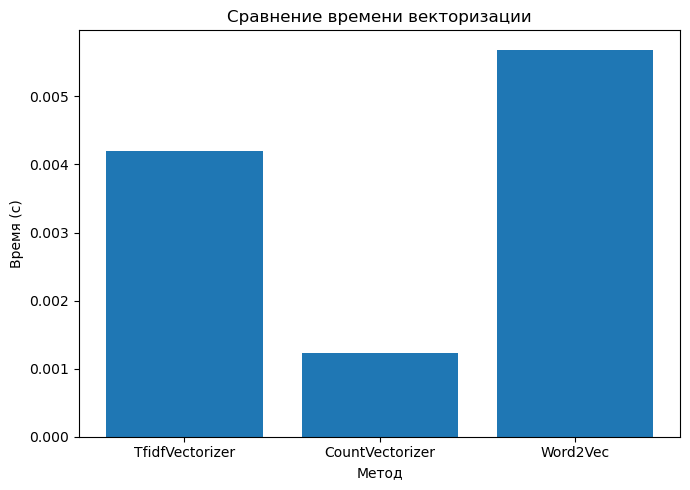

In [7]:
plt.figure(figsize=(7, 5))
plt.bar(list(times.keys()), list(times.values()))
plt.title('Сравнение времени векторизации')
plt.xlabel('Метод')
plt.ylabel('Время (с)')
plt.tight_layout()
plt.show()

### Визуализация результатов методов

#### tfidf

In [8]:
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names, index=["zoloto", "dictofon", "zemfira"])
df_tfidf.head(20)

,бешеный,боль,быть,ваш,век,взлетать,вовсю,время,всё,вчера,...,то,трещина,улетучиться,умолять,устать,уткнуться,хотеться,целый,чайка,это
zoloto,0.066466,0.000000,0.199397,0.000000,0.199397,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.066466,0.066466,0.132931,0.066466,0.066466,0.132931,0.000000,0.199397,0.000000,0.000000
dictofon,0.000000,0.199097,0.000000,0.000000,0.000000,0.199097,0.000000,0.066366,0.132731,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050473
zemfira,0.000000,0.000000,0.000000,0.122605,0.000000,0.000000,0.061303,0.000000,0.000000,0.122605,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.735632,0.000000,0.061303,0.046622


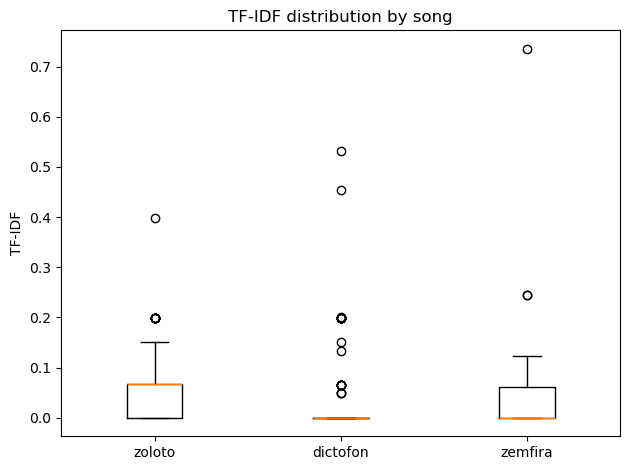

In [9]:
plt.figure()
plt.boxplot([df_tfidf.loc[s].values for s in df_tfidf.index], tick_labels=df_tfidf.index)
plt.title("TF-IDF distribution by song")
plt.ylabel("TF-IDF")
plt.tight_layout()
plt.show()

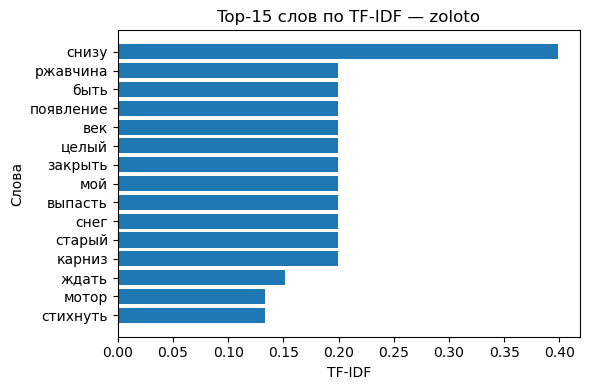

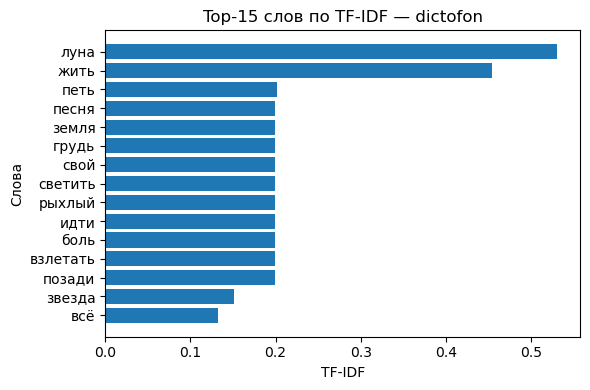

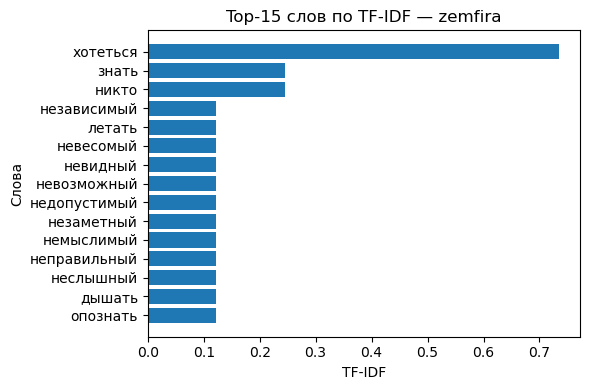

In [10]:
def plot_top_tfidf_per_song(df_tfidf, top_n=15):
    for song in df_tfidf.index:
        top = df_tfidf.loc[song].sort_values(ascending=False).head(top_n)

        plt.figure(figsize=(6, 4))
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title(f"Top-{top_n} слов по TF-IDF — {song}")
        plt.xlabel("TF-IDF")
        plt.ylabel("Слова")
        plt.tight_layout()
        plt.show()

plot_top_tfidf_per_song(df_tfidf, top_n=15)

Распределение TF-IDF значений демонстрирует разреженность матрицы. Большинство слов имеют нулевые веса в отдельных документах, что подтверждает различие лексики между песнями. Наибольшие значения TF-IDF соответствуют тематически специфичным словам.

#### CountVectorizer

In [11]:
feature_names_count = count_vectorizer.get_feature_names_out()
df_count = pd.DataFrame(count_matrix.toarray(), columns=feature_names_count, index=["zoloto", "dictofon", "zemfira"])
df_count.head(20)

,бешеный,боль,быть,ваш,век,взлетать,вовсю,время,всё,вчера,...,то,трещина,улетучиться,умолять,устать,уткнуться,хотеться,целый,чайка,это
zoloto,1,0,3,0,3,0,0,0,0,0,...,1,1,2,1,1,2,0,3,0,0
dictofon,0,3,0,0,0,3,0,1,2,0,...,0,0,0,0,0,0,0,0,0,1
zemfira,0,0,0,2,0,0,1,0,0,2,...,0,0,0,0,0,0,12,0,1,1


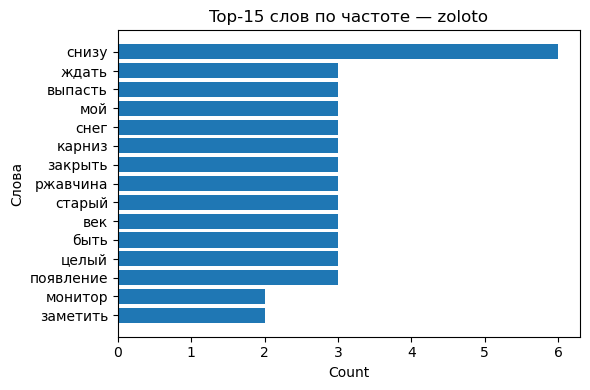

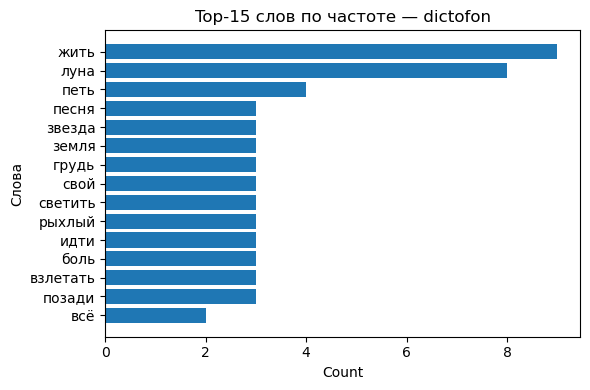

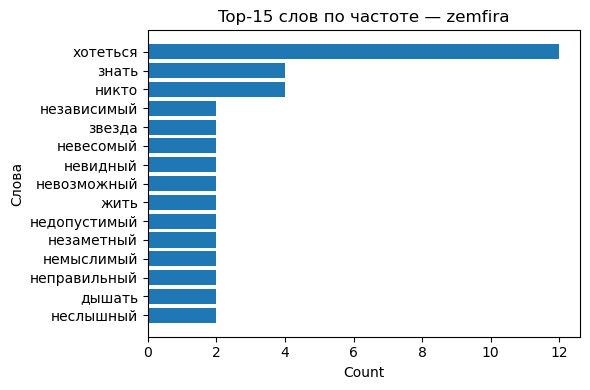

In [12]:
def plot_top_count_per_song(df_count, top_n=15):
    for song in df_count.index:
        top = df_count.loc[song].sort_values(ascending=False).head(top_n)

        plt.figure(figsize=(6,4))
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title(f"Top-{top_n} слов по частоте — {song}")
        plt.xlabel("Count")
        plt.ylabel("Слова")
        plt.tight_layout()
        plt.show()

plot_top_count_per_song(df_count, 15)

Посмотрим биграммы

In [13]:
bigram_vectorizer = CountVectorizer(ngram_range=(2,2))
bigram_matrix = bigram_vectorizer.fit_transform(processed_songs)

bigram_sum = bigram_matrix.sum(axis=0)

bigrams = [(word, bigram_sum[0, idx]) for word, idx in bigram_vectorizer.vocabulary_.items()]

top_bigrams = sorted(bigrams, key=lambda x: x[1], reverse=True)[:10]
top_bigrams

[('жить луна', 8),
 ('выпасть снег', 3),
 ('снег закрыть', 3),
 ('закрыть ржавчина', 3),
 ('ржавчина старый', 3),
 ('старый карниз', 3),
 ('карниз целый', 3),
 ('целый век', 3),
 ('век быть', 3),
 ('быть ждать', 3)]

#### Word2Vec

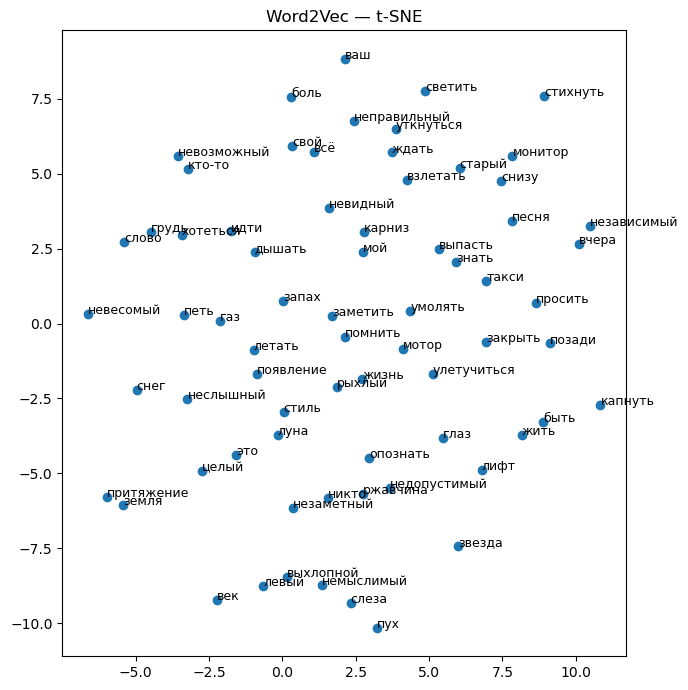

In [14]:
words = list(w2v_model.wv.index_to_key)[:70]
vectors = np.array([w2v_model.wv[w] for w in words])

tsne = TSNE(n_components=2, random_state=42, perplexity=15, init="pca", learning_rate="auto")
reduced = tsne.fit_transform(vectors)

plt.figure(figsize=(7, 7))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, w in enumerate(words):
    plt.text(reduced[i, 0], reduced[i, 1], w, fontsize=9)

plt.title("Word2Vec — t-SNE")
plt.tight_layout()
plt.show()

t-SNE визуализирует семантическое пространство Word2Vec: близко расположенные точки соответствуют словам, которые употребляются в похожих контекстах. t-SNE не показывает важность слов, а отображает структуру их векторных представлений.

#### Облака слов

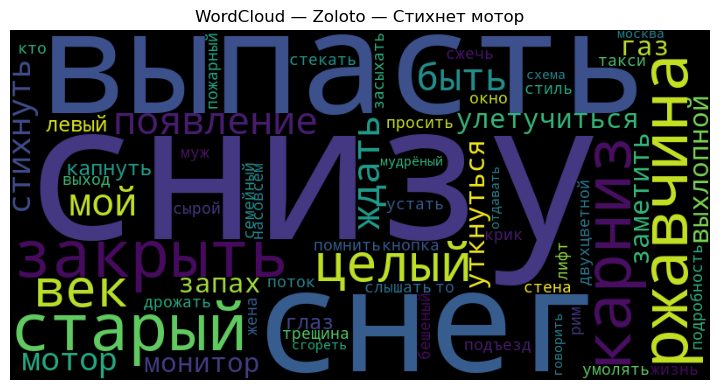

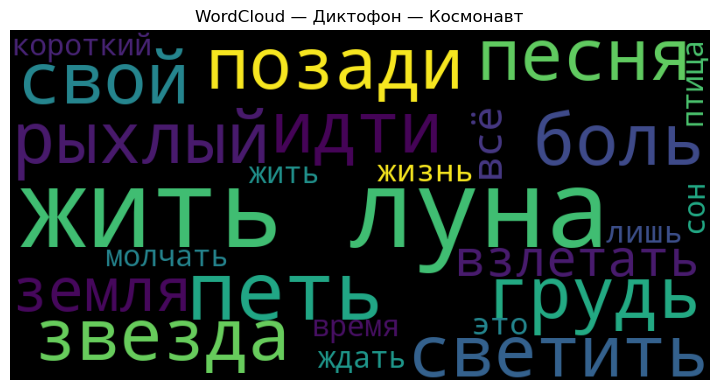

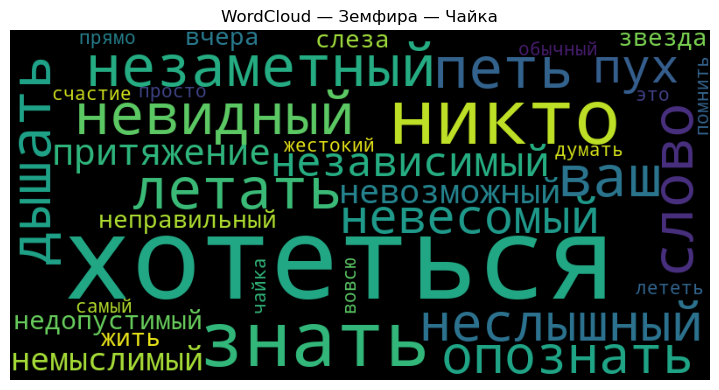

In [15]:
song_names = ["Zoloto — Стихнет мотор",
              "Диктофон — Космонавт",
              "Земфира — Чайка"]

for name, song in zip(song_names, processed_songs):
    wordcloud = WordCloud(width=800, height=400).generate(song)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"WordCloud — {name}")
    plt.tight_layout()
    plt.show()

### Сравнение методов и выводы

In [16]:
cosine_tfidf = cosine_similarity(tfidf_matrix)
cosine_count = cosine_similarity(count_matrix)

print("TF-IDF similarity:\n", cosine_tfidf)
print("Count similarity:\n", cosine_count)

TF-IDF similarity:
 [[1.         0.01020538 0.00235671]
 [0.01020538 1.         0.07765418]
 [0.00235671 0.07765418 1.        ]]
Count similarity:
 [[1.         0.01592842 0.00398942]
 [0.01592842 1.         0.12110112]
 [0.00398942 0.12110112 1.        ]]


In [17]:
def document_vector(text):
    words = text.split()
    return np.mean([w2v_model.wv[w] for w in words if w in w2v_model.wv], axis=0)

doc_vectors = np.array([document_vector(txt) for txt in processed_songs])
cosine_similarity(doc_vectors)

array([[ 0.99999994,  0.09077026, -0.06401138],
       [ 0.09077026,  1.0000001 ,  0.25943866],
       [-0.06401138,  0.25943866,  1.0000001 ]], dtype=float32)

Анализ косинусного сходства показал, что TF-IDF демонстрирует наименьшие значения сходства между разными документами, что указывает на лучшую способность метода выделять специфическую лексику. CountVectorizer показывает более высокие значения сходства, поскольку не учитывает редкость слов в корпусе. Word2Vec демонстрирует чрезмерно высокую схожесть документов, что связано с малым объемом обучающих данных и усреднением векторных представлений. Таким образом, в условиях малого корпуса TF-IDF обеспечивает наиболее информативное и интерпретируемое представление текста.



| Метод             | Интерпретируемость | Подходит для малого корпуса | Учитывает редкость слова |
|------------------|-------------------|----------------------------|--------------------------|
| CountVectorizer | Высокая           | Да                         | Нет                      |
| TF-IDF          | Очень высокая     | Да                         | Да                       |
| Word2Vec        | Низкая            | Нет                        | Нет                      |


## Часть 2

- Используйте предварительно обученную модель BERT для классификации тональности отзывов о фильмах.

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [3]:
df.sample(5)

,review,sentiment
13440,I basically picked up this movie because I had...,negative
15487,"I wouldn't call ""We're Back! A Dinosaur's Stor...",positive
44033,Many experienced and excellent actors mixed to...,positive
47003,Overambitious and shoddy; and at times too dar...,negative
2639,Young Mr. Lincoln marks the first film of the ...,positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
def clean_review(text):
    text = str(text)
    text = re.sub(r"<br\s*/?>", " ", text)      # <br />
    text = re.sub(r"<.*?>", " ", text)          # прочие html-теги
    text = re.sub(r"\s+", " ", text).strip()    # лишние пробелы
    return text

# Убираем NaN 
df = df.dropna(subset=["review", "sentiment"]).copy()

# Чистим
df["review"] = df["review"].map(clean_review)

# Удаляем слишком короткие
df = df[df["review"].str.len() >= 10].copy()

df["label"] = df["sentiment"].str.lower().map({"negative": 0, "positive": 1})

df = df.dropna(subset=["label"]).copy()
df["label"] = df["label"].astype(int)


In [6]:
for review in df['review'].head(3):
    print(review)
    print()

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me. The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word. It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. I would say the main appeal of the show is due to the fact that it goes where other shows 

In [7]:
# разделим на тренировочную и тестовую выборку
train_df, test_df = train_test_split(df[["review", "label"]], test_size=0.2, random_state=42, stratify=df["label"])

In [8]:
# загрузим модель
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [9]:
# подготовим данные
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

def tokenize_batch(batch):
    return tokenizer(batch["review"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize_batch, batched=True)
test_ds  = test_ds.map(tokenize_batch, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

keep_cols = ["input_ids", "attention_mask", "labels"]
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep_cols])
test_ds  = test_ds.remove_columns([c for c in test_ds.column_names  if c not in keep_cols])

train_ds.set_format("torch")
test_ds.set_format("torch")

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
# чтобы показывало шаги обучения
class ProgressCallback(TrainerCallback):
    def __init__(self, print_every=20):
        self.print_every = print_every
        self.t0 = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.t0 = time.time()
        print(f"Training steps: {state.max_steps}")

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step == 0:
            return
        if state.global_step % self.print_every == 0 or state.global_step == state.max_steps:
            elapsed = time.time() - self.t0
            frac = state.global_step / state.max_steps
            eta = elapsed * (1/frac - 1) if frac > 0 else 0
            print(f"{frac*100:6.2f}% | step {state.global_step}/{state.max_steps} | "
                  f"elapsed {elapsed/60:5.1f}m | ETA {eta/60:5.1f}m")

In [11]:
# замораживаем BERT-энкодер, потому что всю модель дообучать очень долго
for p in model.bert.parameters():
    p.requires_grad = False

# разморозим последние N слоёв
N = 2
for layer in model.bert.encoder.layer[-N:]:
    for p in layer.parameters():
        p.requires_grad = True

# разморозим pooler
for p in model.bert.pooler.parameters():
    p.requires_grad = True

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0, 1])
    return {"accuracy": float(acc), "precision_pos": float(p[1]), "recall_pos": float(r[1]), "f1_pos": float(f1[1])}

training_args = TrainingArguments(output_dir="./bert_imdb_head",
                                  eval_strategy="epoch",
                                  num_train_epochs=3,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=16,
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  warmup_ratio=0.06,
                                  report_to="none",
                                  remove_unused_columns=False)

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_ds,   
                  eval_dataset=test_ds,
                  compute_metrics=compute_metrics,
                  callbacks=[ProgressCallback(print_every=50)])

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [13]:
# ограничим число потоков, а то компьютер не справится
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
torch.set_num_threads(2)
torch.set_num_interop_threads(1)

In [14]:
# обучение
trainer.train()

trainer.save_model("./bert_imdb_final")
tokenizer.save_pretrained("./bert_imdb_final")

Training steps: 15000


/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Pos,Recall Pos,F1 Pos
1,0.265544,0.257009,0.910600,0.902549,0.920600,0.911485
2,0.237936,0.295882,0.908700,0.945887,0.867000,0.904727
3,0.207507,0.267578,0.919400,0.914919,0.924800,0.919833


  0.33% | step 50/15000 | elapsed   0.5m | ETA 150.5m
  0.67% | step 100/15000 | elapsed   1.0m | ETA 148.3m
  1.00% | step 150/15000 | elapsed   1.5m | ETA 147.2m
  1.33% | step 200/15000 | elapsed   2.0m | ETA 146.5m
  1.67% | step 250/15000 | elapsed   2.5m | ETA 145.9m
  2.00% | step 300/15000 | elapsed   3.0m | ETA 145.3m
  2.33% | step 350/15000 | elapsed   3.5m | ETA 144.7m
  2.67% | step 400/15000 | elapsed   4.0m | ETA 144.2m
  3.00% | step 450/15000 | elapsed   4.5m | ETA 145.0m
  3.33% | step 500/15000 | elapsed   5.0m | ETA 145.0m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

  3.67% | step 550/15000 | elapsed   5.5m | ETA 145.7m
  4.00% | step 600/15000 | elapsed   6.1m | ETA 145.6m
  4.33% | step 650/15000 | elapsed   6.6m | ETA 145.8m
  4.67% | step 700/15000 | elapsed   7.1m | ETA 145.5m
  5.00% | step 750/15000 | elapsed   7.6m | ETA 145.2m
  5.33% | step 800/15000 | elapsed   8.2m | ETA 144.9m
  5.67% | step 850/15000 | elapsed   8.7m | ETA 144.5m
  6.00% | step 900/15000 | elapsed   9.2m | ETA 144.1m
  6.33% | step 950/15000 | elapsed   9.7m | ETA 143.6m
  6.67% | step 1000/15000 | elapsed  10.2m | ETA 143.1m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

  7.00% | step 1050/15000 | elapsed  10.8m | ETA 142.8m
  7.33% | step 1100/15000 | elapsed  11.3m | ETA 142.4m
  7.67% | step 1150/15000 | elapsed  11.8m | ETA 141.9m
  8.00% | step 1200/15000 | elapsed  12.3m | ETA 141.5m
  8.33% | step 1250/15000 | elapsed  12.8m | ETA 141.1m
  8.67% | step 1300/15000 | elapsed  13.3m | ETA 140.6m
  9.00% | step 1350/15000 | elapsed  13.9m | ETA 140.3m
  9.33% | step 1400/15000 | elapsed  14.4m | ETA 139.9m
  9.67% | step 1450/15000 | elapsed  14.9m | ETA 139.4m
 10.00% | step 1500/15000 | elapsed  15.5m | ETA 139.2m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 10.33% | step 1550/15000 | elapsed  16.0m | ETA 139.0m
 10.67% | step 1600/15000 | elapsed  16.5m | ETA 138.5m
 11.00% | step 1650/15000 | elapsed  17.1m | ETA 138.0m
 11.33% | step 1700/15000 | elapsed  17.6m | ETA 137.5m
 11.67% | step 1750/15000 | elapsed  18.1m | ETA 136.9m
 12.00% | step 1800/15000 | elapsed  18.6m | ETA 136.4m
 12.33% | step 1850/15000 | elapsed  19.1m | ETA 135.9m
 12.67% | step 1900/15000 | elapsed  19.6m | ETA 135.3m
 13.00% | step 1950/15000 | elapsed  20.2m | ETA 134.9m
 13.33% | step 2000/15000 | elapsed  20.7m | ETA 134.4m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 13.67% | step 2050/15000 | elapsed  21.2m | ETA 134.1m
 14.00% | step 2100/15000 | elapsed  21.8m | ETA 133.7m
 14.33% | step 2150/15000 | elapsed  22.3m | ETA 133.2m
 14.67% | step 2200/15000 | elapsed  22.8m | ETA 132.8m
 15.00% | step 2250/15000 | elapsed  23.4m | ETA 132.3m
 15.33% | step 2300/15000 | elapsed  23.9m | ETA 131.9m
 15.67% | step 2350/15000 | elapsed  24.4m | ETA 131.4m
 16.00% | step 2400/15000 | elapsed  24.9m | ETA 130.9m
 16.33% | step 2450/15000 | elapsed  25.5m | ETA 130.6m
 16.67% | step 2500/15000 | elapsed  26.0m | ETA 130.2m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 17.00% | step 2550/15000 | elapsed  26.6m | ETA 129.8m
 17.33% | step 2600/15000 | elapsed  27.1m | ETA 129.4m
 17.67% | step 2650/15000 | elapsed  27.7m | ETA 128.9m
 18.00% | step 2700/15000 | elapsed  28.2m | ETA 128.4m
 18.33% | step 2750/15000 | elapsed  28.7m | ETA 127.9m
 18.67% | step 2800/15000 | elapsed  29.2m | ETA 127.4m
 19.00% | step 2850/15000 | elapsed  29.8m | ETA 126.9m
 19.33% | step 2900/15000 | elapsed  30.3m | ETA 126.4m
 19.67% | step 2950/15000 | elapsed  30.8m | ETA 125.9m
 20.00% | step 3000/15000 | elapsed  31.4m | ETA 125.4m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 20.33% | step 3050/15000 | elapsed  31.9m | ETA 124.9m
 20.67% | step 3100/15000 | elapsed  32.4m | ETA 124.4m
 21.00% | step 3150/15000 | elapsed  32.9m | ETA 123.9m
 21.33% | step 3200/15000 | elapsed  33.5m | ETA 123.4m
 21.67% | step 3250/15000 | elapsed  34.0m | ETA 123.0m
 22.00% | step 3300/15000 | elapsed  34.5m | ETA 122.5m
 22.33% | step 3350/15000 | elapsed  35.1m | ETA 122.0m
 22.67% | step 3400/15000 | elapsed  35.6m | ETA 121.5m
 23.00% | step 3450/15000 | elapsed  36.1m | ETA 121.0m
 23.33% | step 3500/15000 | elapsed  36.7m | ETA 120.5m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 23.67% | step 3550/15000 | elapsed  37.2m | ETA 120.0m
 24.00% | step 3600/15000 | elapsed  37.8m | ETA 119.6m
 24.33% | step 3650/15000 | elapsed  38.4m | ETA 119.3m
 24.67% | step 3700/15000 | elapsed  38.9m | ETA 118.9m
 25.00% | step 3750/15000 | elapsed  39.5m | ETA 118.5m
 25.33% | step 3800/15000 | elapsed  40.1m | ETA 118.1m
 25.67% | step 3850/15000 | elapsed  40.6m | ETA 117.7m
 26.00% | step 3900/15000 | elapsed  41.2m | ETA 117.3m
 26.33% | step 3950/15000 | elapsed  41.8m | ETA 116.8m
 26.67% | step 4000/15000 | elapsed  42.3m | ETA 116.4m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 27.00% | step 4050/15000 | elapsed  42.9m | ETA 116.0m
 27.33% | step 4100/15000 | elapsed  43.5m | ETA 115.5m
 27.67% | step 4150/15000 | elapsed  44.0m | ETA 115.1m
 28.00% | step 4200/15000 | elapsed  44.6m | ETA 114.6m
 28.33% | step 4250/15000 | elapsed  45.1m | ETA 114.2m
 28.67% | step 4300/15000 | elapsed  45.7m | ETA 113.7m
 29.00% | step 4350/15000 | elapsed  46.2m | ETA 113.2m
 29.33% | step 4400/15000 | elapsed  46.8m | ETA 112.7m
 29.67% | step 4450/15000 | elapsed  47.4m | ETA 112.3m
 30.00% | step 4500/15000 | elapsed  47.9m | ETA 111.8m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 30.33% | step 4550/15000 | elapsed  48.5m | ETA 111.4m
 30.67% | step 4600/15000 | elapsed  49.0m | ETA 110.9m
 31.00% | step 4650/15000 | elapsed  49.6m | ETA 110.4m
 31.33% | step 4700/15000 | elapsed  50.2m | ETA 110.0m
 31.67% | step 4750/15000 | elapsed  50.7m | ETA 109.5m
 32.00% | step 4800/15000 | elapsed  51.3m | ETA 109.0m
 32.33% | step 4850/15000 | elapsed  51.9m | ETA 108.5m
 32.67% | step 4900/15000 | elapsed  52.4m | ETA 108.1m
 33.00% | step 4950/15000 | elapsed  53.0m | ETA 107.6m
 33.33% | step 5000/15000 | elapsed  53.5m | ETA 107.1m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


 33.67% | step 5050/15000 | elapsed  61.5m | ETA 121.3m
 34.00% | step 5100/15000 | elapsed  62.1m | ETA 120.6m
 34.33% | step 5150/15000 | elapsed  62.7m | ETA 119.9m
 34.67% | step 5200/15000 | elapsed  63.2m | ETA 119.2m
 35.00% | step 5250/15000 | elapsed  63.8m | ETA 118.5m
 35.33% | step 5300/15000 | elapsed  64.4m | ETA 117.8m
 35.67% | step 5350/15000 | elapsed  64.9m | ETA 117.1m
 36.00% | step 5400/15000 | elapsed  65.5m | ETA 116.4m
 36.33% | step 5450/15000 | elapsed  66.0m | ETA 115.7m
 36.67% | step 5500/15000 | elapsed  66.6m | ETA 115.1m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 37.00% | step 5550/15000 | elapsed  67.2m | ETA 114.4m
 37.33% | step 5600/15000 | elapsed  67.8m | ETA 113.8m
 37.67% | step 5650/15000 | elapsed  68.3m | ETA 113.1m
 38.00% | step 5700/15000 | elapsed  68.9m | ETA 112.4m
 38.33% | step 5750/15000 | elapsed  69.5m | ETA 111.7m
 38.67% | step 5800/15000 | elapsed  70.0m | ETA 111.1m
 39.00% | step 5850/15000 | elapsed  70.6m | ETA 110.4m
 39.33% | step 5900/15000 | elapsed  71.1m | ETA 109.7m
 39.67% | step 5950/15000 | elapsed  71.7m | ETA 109.0m
 40.00% | step 6000/15000 | elapsed  72.3m | ETA 108.4m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 40.33% | step 6050/15000 | elapsed  72.8m | ETA 107.7m
 40.67% | step 6100/15000 | elapsed  73.4m | ETA 107.1m
 41.00% | step 6150/15000 | elapsed  74.0m | ETA 106.4m
 41.33% | step 6200/15000 | elapsed  74.5m | ETA 105.7m
 41.67% | step 6250/15000 | elapsed  75.1m | ETA 105.1m
 42.00% | step 6300/15000 | elapsed  75.6m | ETA 104.4m
 42.33% | step 6350/15000 | elapsed  76.2m | ETA 103.7m
 42.67% | step 6400/15000 | elapsed  76.7m | ETA 103.1m
 43.00% | step 6450/15000 | elapsed  77.3m | ETA 102.4m
 43.33% | step 6500/15000 | elapsed  77.8m | ETA 101.8m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 43.67% | step 6550/15000 | elapsed  78.4m | ETA 101.2m
 44.00% | step 6600/15000 | elapsed  79.0m | ETA 100.5m
 44.33% | step 6650/15000 | elapsed  79.6m | ETA  99.9m
 44.67% | step 6700/15000 | elapsed  80.1m | ETA  99.2m
 45.00% | step 6750/15000 | elapsed  80.7m | ETA  98.6m
 45.33% | step 6800/15000 | elapsed  81.2m | ETA  97.9m
 45.67% | step 6850/15000 | elapsed  81.8m | ETA  97.3m
 46.00% | step 6900/15000 | elapsed  82.4m | ETA  96.7m
 46.33% | step 6950/15000 | elapsed  82.9m | ETA  96.1m
 46.67% | step 7000/15000 | elapsed  83.5m | ETA  95.4m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 47.00% | step 7050/15000 | elapsed  84.1m | ETA  94.8m
 47.33% | step 7100/15000 | elapsed  84.6m | ETA  94.2m
 47.67% | step 7150/15000 | elapsed  85.2m | ETA  93.5m
 48.00% | step 7200/15000 | elapsed  85.7m | ETA  92.9m
 48.33% | step 7250/15000 | elapsed  86.3m | ETA  92.2m
 48.67% | step 7300/15000 | elapsed  86.9m | ETA  91.6m
 49.00% | step 7350/15000 | elapsed  87.4m | ETA  91.0m
 49.33% | step 7400/15000 | elapsed  88.0m | ETA  90.3m
 49.67% | step 7450/15000 | elapsed  88.5m | ETA  89.7m
 50.00% | step 7500/15000 | elapsed  89.1m | ETA  89.1m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 50.33% | step 7550/15000 | elapsed  89.7m | ETA  88.5m
 50.67% | step 7600/15000 | elapsed  90.2m | ETA  87.8m
 51.00% | step 7650/15000 | elapsed  90.8m | ETA  87.2m
 51.33% | step 7700/15000 | elapsed  91.3m | ETA  86.6m
 51.67% | step 7750/15000 | elapsed  91.9m | ETA  86.0m
 52.00% | step 7800/15000 | elapsed  92.4m | ETA  85.3m
 52.33% | step 7850/15000 | elapsed  93.0m | ETA  84.7m
 52.67% | step 7900/15000 | elapsed  93.6m | ETA  84.1m
 53.00% | step 7950/15000 | elapsed  94.1m | ETA  83.5m
 53.33% | step 8000/15000 | elapsed  94.7m | ETA  82.8m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 53.67% | step 8050/15000 | elapsed  95.2m | ETA  82.2m
 54.00% | step 8100/15000 | elapsed  95.8m | ETA  81.6m
 54.33% | step 8150/15000 | elapsed  96.4m | ETA  81.0m
 54.67% | step 8200/15000 | elapsed  96.9m | ETA  80.4m
 55.00% | step 8250/15000 | elapsed  97.5m | ETA  79.8m
 55.33% | step 8300/15000 | elapsed  98.0m | ETA  79.1m
 55.67% | step 8350/15000 | elapsed  98.6m | ETA  78.5m
 56.00% | step 8400/15000 | elapsed  99.1m | ETA  77.9m
 56.33% | step 8450/15000 | elapsed  99.7m | ETA  77.3m
 56.67% | step 8500/15000 | elapsed 100.3m | ETA  76.7m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 57.00% | step 8550/15000 | elapsed 100.8m | ETA  76.1m
 57.33% | step 8600/15000 | elapsed 101.4m | ETA  75.5m
 57.67% | step 8650/15000 | elapsed 102.0m | ETA  74.9m
 58.00% | step 8700/15000 | elapsed 102.5m | ETA  74.2m
 58.33% | step 8750/15000 | elapsed 103.1m | ETA  73.6m
 58.67% | step 8800/15000 | elapsed 103.7m | ETA  73.0m
 59.00% | step 8850/15000 | elapsed 104.2m | ETA  72.4m
 59.33% | step 8900/15000 | elapsed 104.8m | ETA  71.8m
 59.67% | step 8950/15000 | elapsed 105.3m | ETA  71.2m
 60.00% | step 9000/15000 | elapsed 105.9m | ETA  70.6m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 60.33% | step 9050/15000 | elapsed 106.5m | ETA  70.0m
 60.67% | step 9100/15000 | elapsed 107.0m | ETA  69.4m
 61.00% | step 9150/15000 | elapsed 107.6m | ETA  68.8m
 61.33% | step 9200/15000 | elapsed 108.2m | ETA  68.2m
 61.67% | step 9250/15000 | elapsed 108.7m | ETA  67.6m
 62.00% | step 9300/15000 | elapsed 109.3m | ETA  67.0m
 62.33% | step 9350/15000 | elapsed 109.9m | ETA  66.4m
 62.67% | step 9400/15000 | elapsed 110.4m | ETA  65.8m
 63.00% | step 9450/15000 | elapsed 111.0m | ETA  65.2m
 63.33% | step 9500/15000 | elapsed 111.6m | ETA  64.6m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 63.67% | step 9550/15000 | elapsed 112.1m | ETA  64.0m
 64.00% | step 9600/15000 | elapsed 112.7m | ETA  63.4m
 64.33% | step 9650/15000 | elapsed 113.3m | ETA  62.8m
 64.67% | step 9700/15000 | elapsed 113.8m | ETA  62.2m
 65.00% | step 9750/15000 | elapsed 114.4m | ETA  61.6m
 65.33% | step 9800/15000 | elapsed 114.9m | ETA  61.0m
 65.67% | step 9850/15000 | elapsed 115.5m | ETA  60.4m
 66.00% | step 9900/15000 | elapsed 116.1m | ETA  59.8m
 66.33% | step 9950/15000 | elapsed 116.6m | ETA  59.2m
 66.67% | step 10000/15000 | elapsed 117.2m | ETA  58.6m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


 67.00% | step 10050/15000 | elapsed 125.3m | ETA  61.7m
 67.33% | step 10100/15000 | elapsed 125.9m | ETA  61.1m
 67.67% | step 10150/15000 | elapsed 126.4m | ETA  60.4m
 68.00% | step 10200/15000 | elapsed 127.0m | ETA  59.8m
 68.33% | step 10250/15000 | elapsed 127.5m | ETA  59.1m
 68.67% | step 10300/15000 | elapsed 128.1m | ETA  58.5m
 69.00% | step 10350/15000 | elapsed 128.6m | ETA  57.8m
 69.33% | step 10400/15000 | elapsed 129.2m | ETA  57.1m
 69.67% | step 10450/15000 | elapsed 129.7m | ETA  56.5m
 70.00% | step 10500/15000 | elapsed 130.3m | ETA  55.8m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 70.33% | step 10550/15000 | elapsed 130.9m | ETA  55.2m
 70.67% | step 10600/15000 | elapsed 131.4m | ETA  54.6m
 71.00% | step 10650/15000 | elapsed 132.0m | ETA  53.9m
 71.33% | step 10700/15000 | elapsed 132.6m | ETA  53.3m
 71.67% | step 10750/15000 | elapsed 133.1m | ETA  52.6m
 72.00% | step 10800/15000 | elapsed 133.7m | ETA  52.0m
 72.33% | step 10850/15000 | elapsed 134.2m | ETA  51.3m
 72.67% | step 10900/15000 | elapsed 134.8m | ETA  50.7m
 73.00% | step 10950/15000 | elapsed 135.3m | ETA  50.1m
 73.33% | step 11000/15000 | elapsed 135.9m | ETA  49.4m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 73.67% | step 11050/15000 | elapsed 136.5m | ETA  48.8m
 74.00% | step 11100/15000 | elapsed 137.0m | ETA  48.1m
 74.33% | step 11150/15000 | elapsed 137.6m | ETA  47.5m
 74.67% | step 11200/15000 | elapsed 138.1m | ETA  46.9m
 75.00% | step 11250/15000 | elapsed 138.7m | ETA  46.2m
 75.33% | step 11300/15000 | elapsed 139.3m | ETA  45.6m
 75.67% | step 11350/15000 | elapsed 139.8m | ETA  45.0m
 76.00% | step 11400/15000 | elapsed 140.4m | ETA  44.3m
 76.33% | step 11450/15000 | elapsed 140.9m | ETA  43.7m
 76.67% | step 11500/15000 | elapsed 141.5m | ETA  43.1m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 77.00% | step 11550/15000 | elapsed 142.1m | ETA  42.4m
 77.33% | step 11600/15000 | elapsed 142.7m | ETA  41.8m
 77.67% | step 11650/15000 | elapsed 143.2m | ETA  41.2m
 78.00% | step 11700/15000 | elapsed 143.8m | ETA  40.6m
 78.33% | step 11750/15000 | elapsed 144.4m | ETA  39.9m
 78.67% | step 11800/15000 | elapsed 144.9m | ETA  39.3m
 79.00% | step 11850/15000 | elapsed 145.5m | ETA  38.7m
 79.33% | step 11900/15000 | elapsed 146.0m | ETA  38.0m
 79.67% | step 11950/15000 | elapsed 146.6m | ETA  37.4m
 80.00% | step 12000/15000 | elapsed 147.2m | ETA  36.8m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 80.33% | step 12050/15000 | elapsed 147.7m | ETA  36.2m
 80.67% | step 12100/15000 | elapsed 148.3m | ETA  35.5m
 81.00% | step 12150/15000 | elapsed 148.8m | ETA  34.9m
 81.33% | step 12200/15000 | elapsed 149.4m | ETA  34.3m
 81.67% | step 12250/15000 | elapsed 149.9m | ETA  33.7m
 82.00% | step 12300/15000 | elapsed 150.5m | ETA  33.0m
 82.33% | step 12350/15000 | elapsed 151.0m | ETA  32.4m
 82.67% | step 12400/15000 | elapsed 151.6m | ETA  31.8m
 83.00% | step 12450/15000 | elapsed 152.1m | ETA  31.2m
 83.33% | step 12500/15000 | elapsed 152.7m | ETA  30.5m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 83.67% | step 12550/15000 | elapsed 153.3m | ETA  29.9m
 84.00% | step 12600/15000 | elapsed 153.8m | ETA  29.3m
 84.33% | step 12650/15000 | elapsed 154.4m | ETA  28.7m
 84.67% | step 12700/15000 | elapsed 154.9m | ETA  28.1m
 85.00% | step 12750/15000 | elapsed 155.5m | ETA  27.4m
 85.33% | step 12800/15000 | elapsed 156.0m | ETA  26.8m
 85.67% | step 12850/15000 | elapsed 156.6m | ETA  26.2m
 86.00% | step 12900/15000 | elapsed 157.1m | ETA  25.6m
 86.33% | step 12950/15000 | elapsed 157.7m | ETA  25.0m
 86.67% | step 13000/15000 | elapsed 158.3m | ETA  24.3m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 87.00% | step 13050/15000 | elapsed 158.8m | ETA  23.7m
 87.33% | step 13100/15000 | elapsed 159.4m | ETA  23.1m
 87.67% | step 13150/15000 | elapsed 159.9m | ETA  22.5m
 88.00% | step 13200/15000 | elapsed 160.5m | ETA  21.9m
 88.33% | step 13250/15000 | elapsed 161.0m | ETA  21.3m
 88.67% | step 13300/15000 | elapsed 161.6m | ETA  20.7m
 89.00% | step 13350/15000 | elapsed 162.1m | ETA  20.0m
 89.33% | step 13400/15000 | elapsed 162.7m | ETA  19.4m
 89.67% | step 13450/15000 | elapsed 163.2m | ETA  18.8m
 90.00% | step 13500/15000 | elapsed 163.8m | ETA  18.2m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 90.33% | step 13550/15000 | elapsed 164.4m | ETA  17.6m
 90.67% | step 13600/15000 | elapsed 164.9m | ETA  17.0m
 91.00% | step 13650/15000 | elapsed 165.5m | ETA  16.4m
 91.33% | step 13700/15000 | elapsed 166.0m | ETA  15.8m
 91.67% | step 13750/15000 | elapsed 166.6m | ETA  15.1m
 92.00% | step 13800/15000 | elapsed 167.1m | ETA  14.5m
 92.33% | step 13850/15000 | elapsed 167.7m | ETA  13.9m
 92.67% | step 13900/15000 | elapsed 168.2m | ETA  13.3m
 93.00% | step 13950/15000 | elapsed 168.8m | ETA  12.7m
 93.33% | step 14000/15000 | elapsed 169.4m | ETA  12.1m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 93.67% | step 14050/15000 | elapsed 169.9m | ETA  11.5m
 94.00% | step 14100/15000 | elapsed 170.5m | ETA  10.9m
 94.33% | step 14150/15000 | elapsed 171.0m | ETA  10.3m
 94.67% | step 14200/15000 | elapsed 171.6m | ETA   9.7m
 95.00% | step 14250/15000 | elapsed 172.2m | ETA   9.1m
 95.33% | step 14300/15000 | elapsed 172.7m | ETA   8.5m
 95.67% | step 14350/15000 | elapsed 173.3m | ETA   7.8m
 96.00% | step 14400/15000 | elapsed 173.8m | ETA   7.2m
 96.33% | step 14450/15000 | elapsed 174.4m | ETA   6.6m
 96.67% | step 14500/15000 | elapsed 174.9m | ETA   6.0m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

 97.00% | step 14550/15000 | elapsed 175.5m | ETA   5.4m
 97.33% | step 14600/15000 | elapsed 176.1m | ETA   4.8m
 97.67% | step 14650/15000 | elapsed 176.6m | ETA   4.2m
 98.00% | step 14700/15000 | elapsed 177.2m | ETA   3.6m
 98.33% | step 14750/15000 | elapsed 177.7m | ETA   3.0m
 98.67% | step 14800/15000 | elapsed 178.3m | ETA   2.4m
 99.00% | step 14850/15000 | elapsed 178.8m | ETA   1.8m
 99.33% | step 14900/15000 | elapsed 179.4m | ETA   1.2m
 99.67% | step 14950/15000 | elapsed 179.9m | ETA   0.6m
100.00% | step 15000/15000 | elapsed 180.5m | ETA   0.0m


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('./bert_imdb_final/tokenizer_config.json', './bert_imdb_final/tokenizer.json')

In [15]:
metrics = trainer.evaluate()
metrics

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2675779163837433,
 'eval_accuracy': 0.9194,
 'eval_precision_pos': 0.9149188761377127,
 'eval_recall_pos': 0.9248,
 'eval_f1_pos': 0.9198329023274319,
 'eval_runtime': 445.4412,
 'eval_samples_per_second': 22.45,
 'eval_steps_per_second': 1.403,
 'epoch': 3.0}

In [16]:
# загрузка уже обученной нами модели

tokenizer2 = AutoTokenizer.from_pretrained("./bert_imdb_final")
model2 = AutoModelForSequenceClassification.from_pretrained("./bert_imdb_final")
model2.eval()

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# функция для проверки работы
def predict_proba_positive(texts, max_length=256):
    if isinstance(texts, str):
        texts = [texts]
    enc = tokenizer2(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        logits = model2(**enc).logits
        probs = torch.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    return probs

In [18]:
sample_rewiew = "This movie is fantastic, I loved every minute of it!"

prob = predict_proba_positive(sample_rewiew)[0]
print(f"{prob:.3f} -> {'POS' if prob>=0.5 else 'NEG'}")

0.999 -> POS


In [20]:
sample_rewiew = "The movie sucks, a lot of garbage and ugly pictures"

prob = predict_proba_positive(sample_rewiew)[0]
print(f"{prob:.3f} -> {'POS' if prob>=0.5 else 'NEG'}")

0.002 -> NEG


In [19]:
# замер времени
text = "The movie was surprisingly good, nice plot and great acting."

_ = predict_proba_positive(text)

N = 50
t0 = time.time()
for _ in range(N):
    _ = predict_proba_positive(text)
t1 = time.time()

print(f"Avg time: {(t1-t0)/N*1000:.2f} ms")

Avg time: 60.48 ms


После fine-tuning модель показала метрики:

accuracy = 0.92

f1 = 0.92

что соответствует требуемому качеству и демонстрирует хороший баланс precision/recall.


При ручной проверке примеров модель уверенно различает явно положительные и явно отрицательные отзывы, а среднее время инференса на CPU составляет 60 мс на один отзыв.